## Metabolic Markers of Immune Response

Visualization of the results from the immune ~ metabolome regression analyses

In [1]:
import pandas as pds
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
global_rf_models = pds.read_csv('./CVF_ImmuneMarkers_Analysis/VMET2 RF_Regressor_Immune_DESI_NEG.csv')

In [3]:
immune_analysis = pds.ExcelFile("./CVF_ImmuneMarkers_Analysis/VMET2_DESI_NEG_Immune_LinearModels.xls", engine='xlrd')

In [4]:
immune_markers = {}
for x in immune_analysis.sheet_names:
    immune_markers[x] = pds.read_excel(immune_analysis, x)

In [5]:
# Select only markers
which_markers = ['CVF IL-1beta', 'CVF IL-8',  'CVF MBL', 'CVF C5a', 'CVF C3b_iC3b', 
                 'CVF IgE', 'CVF IgG2', 'CVF IgG3', 'CVF IgG4', 'CVF IgM']

In [12]:
# Load the annotation for the compounds for the figure legends
compoundIds = pds.read_csv('../../Data/Extended Data Table 3 ImmuneMarkers.csv')

Specify a cut-off criteria to display markers - Here is an $r^{2}$ value greater than 0.1 and statistically different from 0 (r2 $\neq$ 0, q-value < 0.05, FDR corrected with Benjamini-Hochberg).

In [6]:
r2_criteria = 0.1
r2_qval_criteria = 0.05
markers = list()
for x in range(22):
    markers.append(set(immune_markers[list(immune_markers.keys())[x]].loc[(immune_markers[list(immune_markers.keys())[x]]['R2'] > r2_criteria) & (immune_markers[list(immune_markers.keys())[x]]['R2_qval'] < r2_qval_criteria), 'Metabolite']))

In [7]:
selected_markers = set.union(*markers)

In [8]:
r2_vals = list()
for marker in which_markers:
    for metabolite in selected_markers:
        #r2_vals.append(np.sign(immune_markers[marker].loc[immune_markers[marker]['Metabolite'].isin(set.union(*markers)), 'tvalue']) * immune_markers[marker].loc[immune_markers[marker]['Metabolite'].isin(set.union(*markers)), 'R2'])
        r2_vals.append(immune_markers[marker].loc[immune_markers[marker]['Metabolite'] == metabolite, 'tvalue'].values)

r2_sign = np.array(r2_vals).reshape((len(which_markers), len(selected_markers)))
#r2_sign = np.vstack(r2_vals)


In [9]:
selected_markers = np.array(list(selected_markers))

In [27]:
sort_by_tstat = r2_sign.mean(0).argsort()
r2_sign = r2_sign[:, sort_by_tstat]
markers_x_labels = [round(x, 4) for x in selected_markers[sort_by_tstat]]
annotateNames = pds.DataFrame([np.r_[x, compoundIds.loc[np.argmin(np.abs(compoundIds['m/z measured']- x)), ['m/z measured', 'Metabolite Annotation']]] for x in markers_x_labels])
markers_x_labels = annotateNames.iloc[:, 2]

Generate the heatmaps from Figure 4 (A and B).

<ipython-input-30-382bae136f78>:46: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  divnorm = colors.DivergingNorm(vmin=r2_sign.min(), vcenter=0, vmax=r2_sign.max())


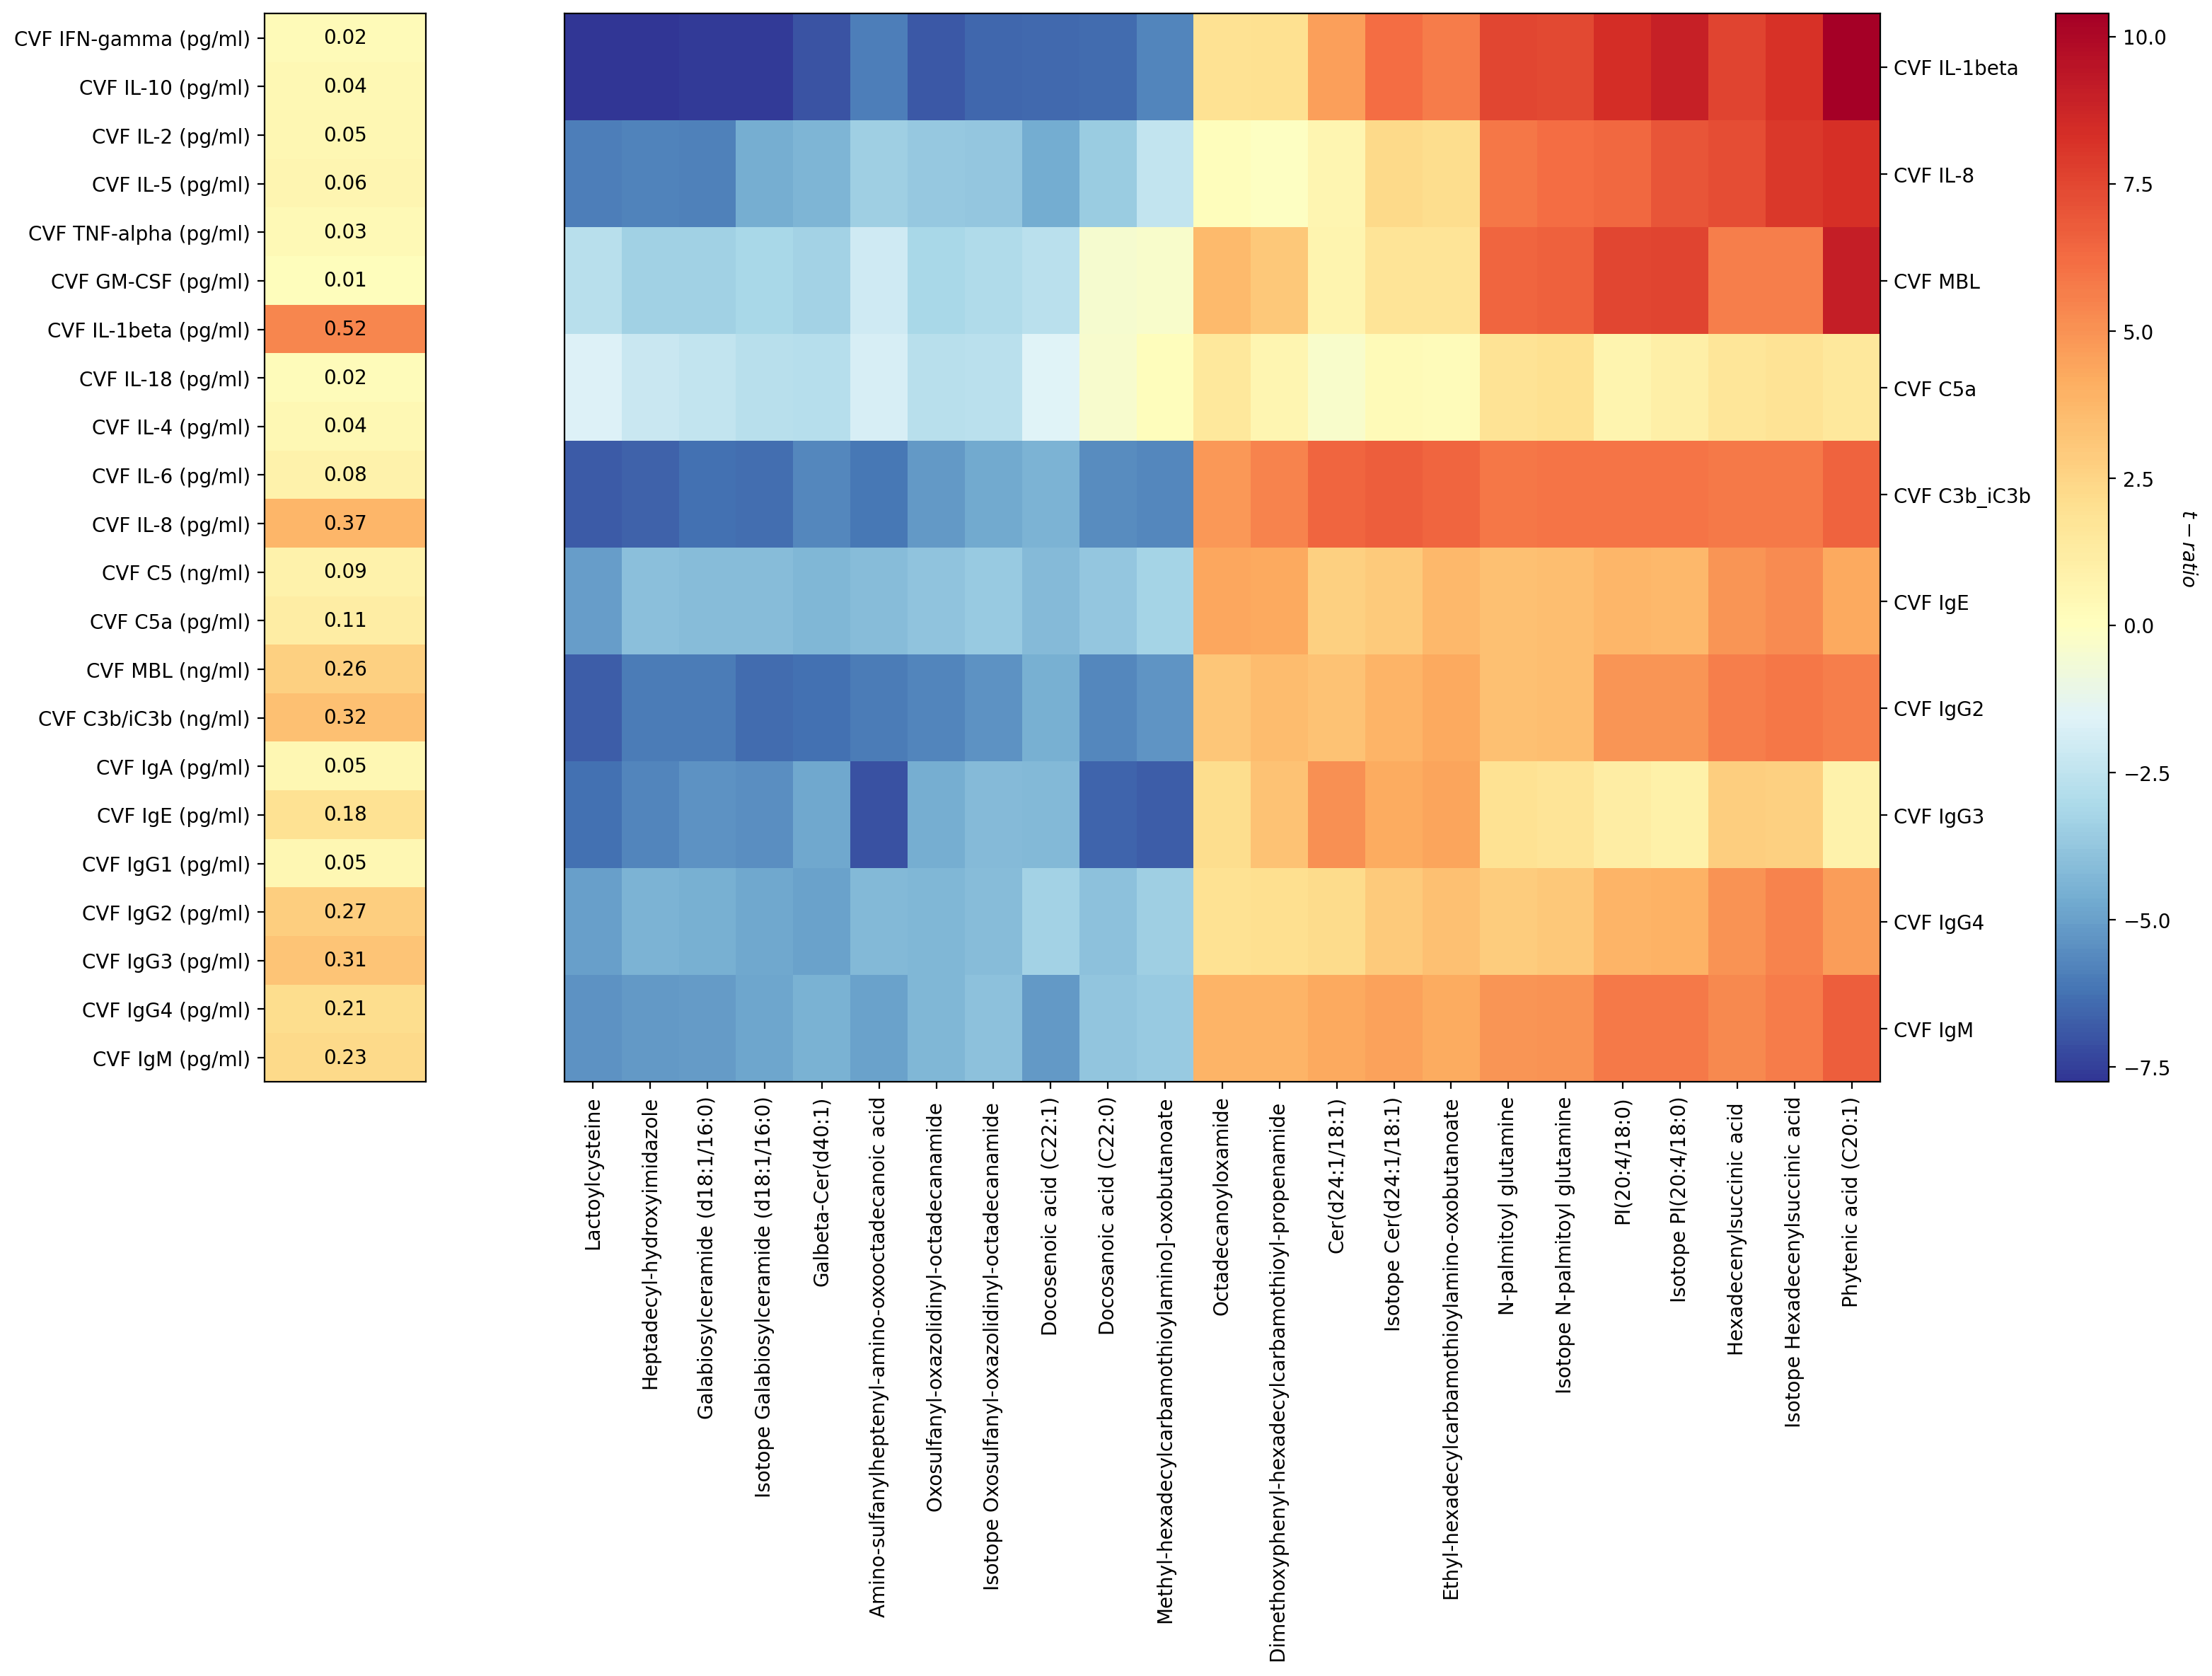

In [30]:
#fig, axes = plt.subplots(1, 2, dpi=200, figsize=(20, 10))
from matplotlib import gridspec
from matplotlib import colors

fig = plt.figure(figsize = (20,10), dpi=200)

gs1 = gridspec.GridSpec(1, 5)

gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

axes = list()
axes.append(plt.subplot(gs1[0]))
axes.append(plt.subplot(gs1[1:]))


r2_rf = axes[0].imshow(global_rf_models['Rsquared'].values[:, None], cmap='RdYlBu_r', vmax=1, vmin=-1)

axes[0].set_yticks(np.arange(global_rf_models.shape[0]))
axes[0].set_yticklabels(global_rf_models['ImmuneMarker'].values)
axes[0].set_xticks([])
axes[0].set_xticklabels([])

valfmt = mpl.ticker.StrMethodFormatter("{x:.2f}")

for i in range(global_rf_models.shape[0]):
    axes[0].text(0, i, valfmt(global_rf_models['Rsquared'][i]), horizontalalignment='center', 
                 verticalalignment='center')

axes[0].set_aspect(0.3)

divnorm = colors.DivergingNorm(vmin=r2_sign.min(), vcenter=0, vmax=r2_sign.max())

axes[1].set_yticks(np.arange(len(which_markers)))
axes[1].set_yticklabels(which_markers)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set_xticks(range(len(set.union(*markers))))
axes[1].set_xticklabels(markers_x_labels, rotation=90)

#r2_markers = axes[1].imshow(r2_sign, cmap='RdYlGn', vmax=1, vmin=-1)
r2_markers = axes[1].imshow(r2_sign, cmap='RdYlBu_r', norm=divnorm)

axes[1].set_aspect('auto')

#fig.subplots_adjust(wspace=0, hspace=0, right=0.8)

#position=fig.add_axes([0.85,0.1,0.025,1])  ## the parameters are the specified position you set 

#fig1.colorbar(sc,cax=position) ## 

cbar = axes[1].figure.colorbar(r2_markers, pad=0.1)
#cbar.ax.set_ylabel(r'$R^{2}  \times  sign(\beta)$', rotation=-90, va="bottom")
cbar.ax.set_ylabel(r'$t-ratio$', rotation=-90, va="bottom")

fig.savefig('./CVF_ImmuneMarkers_Analysis/Figure 4 Heatmap.png', bbox_inches='tight')